In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## 1) Обработка данных студентов

Цели:
- Сравнить средние баллы за три сессии ЕГЭшников и Олимпиадников, тем самым, ответив на вопрос: стоит ли готовиться к олимпиадам, дают ли они преимущество при учебе в университете или можно просто готовиться к ЕГЭ.
- Обучить модель, которая предсказывала бы средний балл за три сессии по баллам ЕГЭ и наличию аттестата с отличием,	сочинения, золотого значка ГТО и права на общежитие.

Импортируем файл с данными студентов:

In [2]:
Students = pd.read_csv('Students.csv', header = 0)

In [3]:
Students.shape

(381, 12)

In [4]:
Students.head()

,N зачетки,Ф И О,Экз.гр,оц,5,4,3,2,0,п/сдач,Балл,Рейт
0,3200617,Комарова Ирина Алексеевна,201,14,14,0,0,0,0,0,70,0
1,3200500,Тарасенков Александр Николаевич,201,14,14,0,0,0,0,0,70,0
2,3200330,Гордеев Артем Павлович,202,17,17,0,0,0,0,0,85,0
3,3200410,Михайлова Варвара Игоревна,202,17,17,0,0,0,0,0,85,0
4,3200400,Линовский Георгий Павлович,206,17,17,0,0,0,0,0,85,0


Видно, что количество оценок у учеников различается.

In [5]:
Students.value_counts('оц')

оц
17    336
14     22
12      5
16      5
11      4
15      4
10      2
13      2
5       1
dtype: int64

Большинство оценок равно 17.

Нормируем баллы:

In [6]:
Students['Балл'] = Students['Балл'] / Students['оц'] * 17
Students.head()

,N зачетки,Ф И О,Экз.гр,оц,5,4,3,2,0,п/сдач,Балл,Рейт
0,3200617,Комарова Ирина Алексеевна,201,14,14,0,0,0,0,0,85.0,0
1,3200500,Тарасенков Александр Николаевич,201,14,14,0,0,0,0,0,85.0,0
2,3200330,Гордеев Артем Павлович,202,17,17,0,0,0,0,0,85.0,0
3,3200410,Михайлова Варвара Игоревна,202,17,17,0,0,0,0,0,85.0,0
4,3200400,Линовский Георгий Павлович,206,17,17,0,0,0,0,0,85.0,0


Уберем столбцы, которые больше не понадобятся:

In [7]:
# Создаем таблицу с метрикой, которую мы будем объединять с таблицей EGE_Abiturients
Ball = Students.loc[ :, ['Ф И О', 'Балл']]
Ball.head()

,Ф И О,Балл
0,Комарова Ирина Алексеевна,85.0
1,Тарасенков Александр Николаевич,85.0
2,Гордеев Артем Павлович,85.0
3,Михайлова Варвара Игоревна,85.0
4,Линовский Георгий Павлович,85.0


Чтобы в дальнейшем объединить таблицу студентов с таблицей баллов ЕГЭ, изменим название столбца "Ф И О" на "Ф.И.О" и приведем имена к верхнему регистру:

In [8]:
Ball['Ф И О'] = Ball['Ф И О'].str.upper()

Ball.rename(columns={'Ф И О': 'Ф.И.О'}, inplace=True)

Ball.head()

,Ф.И.О,Балл
0,КОМАРОВА ИРИНА АЛЕКСЕЕВНА,85.0
1,ТАРАСЕНКОВ АЛЕКСАНДР НИКОЛАЕВИЧ,85.0
2,ГОРДЕЕВ АРТЕМ ПАВЛОВИЧ,85.0
3,МИХАЙЛОВА ВАРВАРА ИГОРЕВНА,85.0
4,ЛИНОВСКИЙ ГЕОРГИЙ ПАВЛОВИЧ,85.0


## 2) Обработка данных абитуриентов

Импортируем файл с данными абитуриентов:

In [9]:
Abiturients = pd.read_csv('Abiturients.csv', header = 0)

In [10]:
Abiturients.shape

(419, 11)

In [11]:
Abiturients.head()

,Ф.И.О,Льготы,Сумма баллов,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие
0,БАБУШКИН КИРИЛЛ ПАВЛОВИЧ,NaN,305.0,81.0,64.0,76.0,82.0,0.0,2.0,0.0,Нет
1,СЕДЕНЬ АНТОН СЕРГЕЕВИЧ,NaN,297.0,39.0,81.0,82.0,87.0,6.0,2.0,0.0,Да
2,УВАРИЧЕВ МАКСИМ БОРИСОВИЧ,NaN,296.0,47.0,76.0,76.0,87.0,6.0,2.0,2.0,Нет
3,ВЫСОТИН СТЕПАН АЛЕКСЕЕВИЧ,NaN,248.0,36.0,62.0,80.0,70.0,0.0,0.0,0.0,Да
4,ЕФИМОВ РУСЛАН АЛЕКСАНДРОВИЧ,NaN,195.0,46.0,42.0,39.0,66.0,0.0,2.0,0.0,Нет


Посмотрим на стык абитуриентов с льготами и ЕГЭ:

In [12]:
Abiturients['Сумма баллов'].count(None)

125

In [13]:
Abiturients.iloc[[i for i in range(123, 129)]]

,Ф.И.О,Льготы,Сумма баллов,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие
123,КАРАМНОВ МАКСИМ ИГОРЕВИЧ,NaN,348.0,100.0,97.0,76.0,73.0,0.0,2.0,0.0,Нет
124,ФЕДОТОВА АНАСТАСИЯ ЕВГЕНЬЕВНА,NaN,347.0,69.0,97.0,88.0,91.0,0.0,2.0,0.0,Да
125,ВАХОНИН АРТЕМИЙ АНДРЕЕВИЧ,Призер Всероссийской олимпиады школьников,NaN,NaN,NaN,NaN,NaN,6.0,2.0,0.0,Нет
126,NaN,Призер олимпиады № 36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,ТАРАСЕНКОВ АЛЕКСАНДР НИКОЛАЕВИЧ,Призер Всероссийской олимпиады школьников,NaN,NaN,NaN,NaN,NaN,6.0,2.0,0.0,Нет
128,ГОРАН АРСЕНИЙ ПАВЛОВИЧ,Победитель Всероссийской олимпиады школьников,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,Да


Как оказалось, у абитуриентов с несколькими олимпиадами вторая и т.д. олимпиады выносятся в отдельную строку. Эти строки нам не нужны, удалим их:

In [14]:
Abiturients = Abiturients.dropna(thresh=2)

In [15]:
Abiturients.shape

(343, 11)

Приведем к бинарному виду столбцы: "Право на общежитие", "ГТО", "Сочинение, "Аттестат с отличием":

In [16]:
Abiturients = Abiturients.replace({'Право на общежитие':{'Да':1, 'Нет':0}, 'ГТО':{2:1},
                                   'Сочинение':{2:1}, 'Аттестат с отличием':{6:1}})
Abiturients.head()

,Ф.И.О,Льготы,Сумма баллов,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие
0,БАБУШКИН КИРИЛЛ ПАВЛОВИЧ,NaN,305.0,81.0,64.0,76.0,82.0,0.0,1.0,0.0,0
1,СЕДЕНЬ АНТОН СЕРГЕЕВИЧ,NaN,297.0,39.0,81.0,82.0,87.0,1.0,1.0,0.0,1
2,УВАРИЧЕВ МАКСИМ БОРИСОВИЧ,NaN,296.0,47.0,76.0,76.0,87.0,1.0,1.0,1.0,0
3,ВЫСОТИН СТЕПАН АЛЕКСЕЕВИЧ,NaN,248.0,36.0,62.0,80.0,70.0,0.0,0.0,0.0,1
4,ЕФИМОВ РУСЛАН АЛЕКСАНДРОВИЧ,NaN,195.0,46.0,42.0,39.0,66.0,0.0,1.0,0.0,0


Разобьем таблицу абитуриентов на две таблицы: абитуриентов с льготами и абитуриентов с баллами ЕГЭ:

In [17]:
EGE_Abiturients = Abiturients[:125]
Lgoti_Abiturients = Abiturients[125:]

Уберем в EGE_Abiturients столбец "Льготы" и "Сумма баллов", а в  Lgoti_Abiturients столбцы с баллами ЕГЭ и столбец "Сумма баллов":

In [18]:
EGE_Abiturients = EGE_Abiturients.drop(['Льготы', 'Сумма баллов'], axis = 1)
EGE_Abiturients.head()

,Ф.И.О,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие
0,БАБУШКИН КИРИЛЛ ПАВЛОВИЧ,81.0,64.0,76.0,82.0,0.0,1.0,0.0,0
1,СЕДЕНЬ АНТОН СЕРГЕЕВИЧ,39.0,81.0,82.0,87.0,1.0,1.0,0.0,1
2,УВАРИЧЕВ МАКСИМ БОРИСОВИЧ,47.0,76.0,76.0,87.0,1.0,1.0,1.0,0
3,ВЫСОТИН СТЕПАН АЛЕКСЕЕВИЧ,36.0,62.0,80.0,70.0,0.0,0.0,0.0,1
4,ЕФИМОВ РУСЛАН АЛЕКСАНДРОВИЧ,46.0,42.0,39.0,66.0,0.0,1.0,0.0,0


In [19]:
Lgoti_Abiturients = Lgoti_Abiturients.drop(['ФИЗИКА(ДВИ)', 'Сумма баллов', 'ФИЗИКА(ЕГЭ)',
                                            'МАТЕМАТИКА(ЕГЭ)', 'РУССКИЙ ЯЗЫК(ЕГЭ)'], axis = 1)
Lgoti_Abiturients.head()

,Ф.И.О,Льготы,Аттестат с отличием,Сочинение,ГТО,Право на общежитие
125,ВАХОНИН АРТЕМИЙ АНДРЕЕВИЧ,Призер Всероссийской олимпиады школьников,1.0,1.0,0.0,0
127,ТАРАСЕНКОВ АЛЕКСАНДР НИКОЛАЕВИЧ,Призер Всероссийской олимпиады школьников,1.0,1.0,0.0,0
128,ГОРАН АРСЕНИЙ ПАВЛОВИЧ,Победитель Всероссийской олимпиады школьников,0.0,1.0,0.0,1
129,ОСТАПОВИЧ ДМИТРИЙ СЕРГЕЕВИЧ,Призер Всероссийской олимпиады школьников,1.0,1.0,0.0,0
130,ГОРДЕЕВ АРТЕМ ПАВЛОВИЧ,Призер Всероссийской олимпиады школьников,0.0,1.0,0.0,1


## 3) Анализ данных

In [20]:
print('Количество абитуриентов = ' + str(len(Abiturients)))
print('Количество абитуриентов с льготами = ' + str(len(Lgoti_Abiturients)))
print('Количество абитуриентов с баллами ЕГЭ = ' + str(len(EGE_Abiturients)))

Количество абитуриентов = 343
Количество абитуриентов с льготами = 218
Количество абитуриентов с баллами ЕГЭ = 125


Сопоставим таблицу абитуриентов с таблицей с баллами за три сессии чтобы узнать, кто лучше учится Егэшники или Льготники:

In [21]:
Lgoti_df = Lgoti_Abiturients.merge(Ball)
EGE_df = EGE_Abiturients.merge(Ball)

In [22]:
print(Lgoti_df.shape)
print(EGE_df.shape)

(191, 7)
(109, 10)


После совмещения таблиц абитуриентов и студентов, размеры таблиц уменьшились на количество исключенных/ушедших в академический отпуск/переведенных в другой вуз людей. Посчитаем количество отстраненных от учебы студентов:

In [23]:
print('Количество людей, поступавших по льготам, отсраненных от учебы = ' + str(len(Lgoti_Abiturients) - Lgoti_df.shape[0]))
print('Количество людей, поступавших по ЕГЭ, отсраненных от учебы = ' + str(len(EGE_Abiturients) - EGE_df.shape[0]))

print('Количество людей, поступавших по льготам, отсраненных от учебы в процентах = ' + str((len(Lgoti_Abiturients) - Lgoti_df.shape[0]) / Lgoti_df.shape[0]))
print('Количество людей, поступавших по ЕГЭ, отсраненных от учебы в процентах = ' + str((len(EGE_Abiturients) - EGE_df.shape[0]) / EGE_df.shape[0]))

Количество людей, поступавших по льготам, отсраненных от учебы = 27
Количество людей, поступавших по ЕГЭ, отсраненных от учебы = 16
Количество людей, поступавших по льготам, отсраненных от учебы в процентах = 0.14136125654450263
Количество людей, поступавших по ЕГЭ, отсраненных от учебы в процентах = 0.14678899082568808


Как оказалось, количество отстраненных студентов, несильно зависит от способа поступления в ВУЗ.

Проанализируем Льготников и Егэшников с помощью describe():

In [24]:
Lgoti_df.describe()

,Аттестат с отличием,Сочинение,ГТО,Право на общежитие,Балл
count,191.000000,191.0,191.000000,191.000000,191.000000
mean,0.376963,1.0,0.183246,0.670157,75.758742
std,0.485899,0.0,0.387885,0.471392,7.806466
min,0.000000,1.0,0.000000,0.000000,43.562500
25%,0.000000,1.0,0.000000,0.000000,72.000000
50%,0.000000,1.0,0.000000,1.000000,78.000000
75%,1.000000,1.0,0.000000,1.000000,81.178571
max,1.000000,1.0,1.000000,1.000000,85.000000


In [25]:
EGE_df.describe()

,ФИЗИКА(ДВИ),ФИЗИКА(ЕГЭ),МАТЕМАТИКА(ЕГЭ),РУССКИЙ ЯЗЫК(ЕГЭ),Аттестат с отличием,Сочинение,ГТО,Право на общежитие,Балл
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,86.880734,92.706422,88.678899,92.055046,0.541284,0.981651,0.183486,0.596330,73.246068
std,11.062721,6.173874,6.382674,5.857624,0.500594,0.134829,0.388852,0.492899,8.820134
min,39.000000,64.000000,74.000000,73.000000,0.000000,0.000000,0.000000,0.000000,45.000000
25%,80.000000,91.000000,84.000000,89.000000,0.000000,1.000000,0.000000,0.000000,69.000000
50%,87.000000,93.000000,88.000000,94.000000,1.000000,1.000000,0.000000,1.000000,74.000000
75%,97.000000,97.000000,94.000000,96.000000,1.000000,1.000000,0.000000,1.000000,80.000000
max,100.000000,100.000000,100.000000,100.000000,1.000000,1.000000,1.000000,1.000000,85.000000


- Средний балл Льготников (75.758742) немного больше, чем у Егэшников (73.246068)
- У Егэшников количество аттестатов с отличием (0.541284), в среднем, значительно больше, чем у Льготников (0.376963)
- Льготникам общежитие требуется чаще (0.670157), чем Егэшникам (0.596330)

Построим гистограмму баллов Егэшников и Льготников:

Text(0.5, 1.0, 'Гистограмма количества Льготников и Егэшников \n в зависимости от среднего балла за три сессии')

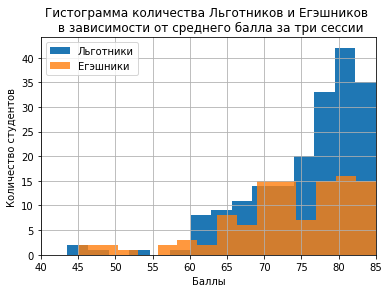

In [26]:
Lgoti_df.Балл.hist(bins = 15)
EGE_df.Балл.hist(bins = 15, alpha = 0.8)
plt.xlim(40, 85)

plt.legend(['Льготники', 'Егэшники'])
plt.xlabel('Баллы')
plt.ylabel('Количество студентов')
plt.title('Гистограмма количества Льготников и Егэшников \n в зависимости от среднего балла за три сессии')

Нормируем данные, чтобы стало проще сравнивать:

Text(0.5, 1.0, 'Нормированная гистограмма количества Льготников и Егэшников \n в зависимости от среднего балла за три сессии')

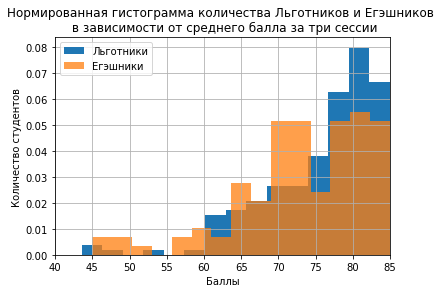

In [27]:
Lgoti_df.Балл.hist(bins = 15, density = True)
EGE_df.Балл.hist(bins = 15, alpha = 0.75, density = True)
plt.xlim(40, 85)

plt.legend(['Льготники', 'Егэшники'])
plt.xlabel('Баллы')
plt.ylabel('Количество студентов')
plt.title('Нормированная гистограмма количества Льготников и Егэшников \n в зависимости от среднего балла за три сессии')

Выводы из гистограммы:
- Количество Егэшников с баллом < 60 значительно больше, чем Льготников
- Льготников с баллами > 75 значительно больше, чем Егэшников

Построим еще один график:

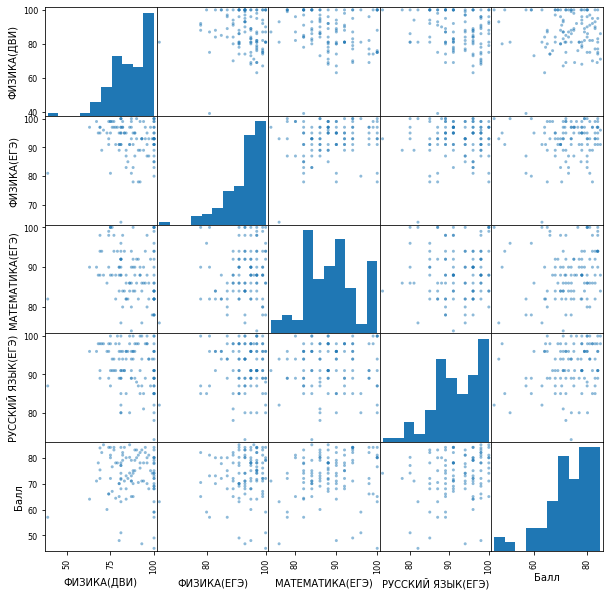

In [28]:
a = pd.plotting.scatter_matrix(EGE_df[['ФИЗИКА(ДВИ)', 'ФИЗИКА(ЕГЭ)', 'МАТЕМАТИКА(ЕГЭ)', 'РУССКИЙ ЯЗЫК(ЕГЭ)', 'Балл']],
                               figsize=(10, 10))

Нас интересует нижняя строка: зависимость Балла от баллов за различные предметы ЕГЭ, т.к. далее мы будем обучать модель, которая как раз будет предсказывать Балл по баллам ЕГЭ (и еще нескольким параметрам).

## 4) Выбор лучшей модели

In [29]:
# Выделяем массив объектов
X = np.array(EGE_df[['ФИЗИКА(ДВИ)', 'ФИЗИКА(ЕГЭ)', 'МАТЕМАТИКА(ЕГЭ)', 'РУССКИЙ ЯЗЫК(ЕГЭ)','Аттестат с отличием',
                'Сочинение', 'ГТО', 'Право на общежитие']])

# Выделяем массив ответов
y = np.array(EGE_df['Балл'])

# Делим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

- Регрессия k ближайших соседей
- Линейная регрессия
- Гребневая регрессия
- Лассо регрессия
- Ансамбль деревьев регрессии
- Градиентный бустинг деревьев регрессии
- Нейронные сети

In [30]:
# Регрессия k ближайших соседей

knr = KNeighborsRegressor(n_neighbors=4).fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.2f}".format(knr.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(knr.score(X_test, y_test)))

Правильность на обучающем наборе: 0.26
Правильность на тестовом наборе: -0.37


In [31]:
# Линейная регрессия

lr = LinearRegression().fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.2f}".format(lr.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(lr.score(X_test, y_test)))

Правильность на обучающем наборе: 0.08
Правильность на тестовом наборе: 0.07


In [32]:
# Гребневая регрессия

ridge = Ridge(alpha=0.0001).fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.2f}".format(ridge.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(ridge.score(X_test, y_test)))

Правильность на обучающем наборе: 0.08
Правильность на тестовом наборе: 0.07


In [33]:
# Лассо регрессия

lasso001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(lasso001.score(X_test, y_test)))

Правильность на обучающем наборе: 0.08
Правильность на тестовом наборе: 0.07


In [34]:
# Ансамбль деревьев регрессии

forest = RandomForestRegressor(n_estimators=1000, random_state=0, max_depth=3)
forest.fit(X_train, y_train)

print("Правильность на обучающем наборе: {:.3f}".format(forest.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(forest.score(X_test, y_test)))

Правильность на обучающем наборе: 0.461
Правильность на тестовом наборе: -0.299


In [35]:
# Градиентный бустинг деревьев регрессии

GBC = GradientBoostingRegressor(random_state=0)
GBC.fit(X_train, y_train)

print("Правильность на обучающем наборе: {:.3f}".format(GBC.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(GBC.score(X_test, y_test)))

Правильность на обучающем наборе: 0.940
Правильность на тестовом наборе: -1.002


In [36]:
# Нейронные сети

# Нормируем
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Neyr = MLPRegressor(random_state=0, max_iter=100000, 
                    hidden_layer_sizes = [20])
Neyr.fit(X_train_scaled, y_train)

print("Правильность на обучающем наборе: {:.3f}".format(Neyr.score(X_train_scaled, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(Neyr.score(X_test_scaled, y_test)))

Правильность на обучающем наборе: 0.987
Правильность на тестовом наборе: -3.443


In [37]:
# Сортируем правильность моделей

models = pd.DataFrame({
    'Model': ['Регрессия k ближайших соседей','Линейная регрессия', 'Гребневая регрессия', 'Лассо регрессия', 
             'Ансамбль деревьев регрессии', 'Градиентный бустинг деревьев регрессии', 'Нейронные сети'],
    'Score': [knr.score(X_test, y_test), lr.score(X_test, y_test), ridge.score(X_test, y_test),
              lasso001.score(X_test, y_test), forest.score(X_test, y_test), GBC.score(X_test, y_test),
              Neyr.score(X_test_scaled, y_test)]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Лассо регрессия,0.072664
2,Гребневая регрессия,0.072660
1,Линейная регрессия,0.072660
4,Ансамбль деревьев регрессии,-0.298640
0,Регрессия k ближайших соседей,-0.374298
5,Градиентный бустинг деревьев регрессии,-1.001772
6,Нейронные сети,-3.443057


Линейные модели показывают лучший результат. Рассмотрим Лассо регрессию подробнее:

In [38]:
# Посмотрим на коэффициенты:
print("Количество использованных признаков: {}".format(np.sum(lasso001.coef_ != 0)))
print()

for i, j in zip(EGE_df.columns[1:9], lasso001.coef_):
    print('Вес ' + str(i) + ' = ' + str(j))
# забавно что физика и дви по физике меньше всего влияют на то,
# какой будет средний балл

Количество использованных признаков: 8

Вес ФИЗИКА(ДВИ) = 0.1099923807928719
Вес ФИЗИКА(ЕГЭ) = 0.13179194340573833
Вес МАТЕМАТИКА(ЕГЭ) = 0.22212521153517906
Вес РУССКИЙ ЯЗЫК(ЕГЭ) = 0.18571339153869923
Вес Аттестат с отличием = 1.599147689291475
Вес Сочинение = 0.727689149175886
Вес ГТО = 0.37710040502822795
Вес Право на общежитие = -0.10957389013570505


- Вес ФИЗИКА(ДВИ) и Вес ФИЗИКА(ЕГЭ) имеют наименьшие значения среди всех предметов (хотя факультет ФИЗИЧЕСКИЙ)
- Вес Аттестат с отличием имеет очень высокое значение относительно других бинарных параметров
- Право на общежитие единственный отрицательный параметр

Предсказание среднего балла за 3 сессии:

In [39]:
# Прогноз на одного конкретного человека (MAX = 85)

# ВВЕДИТЕ ВАШИ ДАННЫЕ
# [0, 100]
FIZIKA_DVI = 100
FIZIKA_EGE = 97
MATEMATIKA_EGE = 74
RUSSKIY_YAZIK_EGE = 91

# 1 или 0
ATTESTAT_S_OTLICHIEM = 0
SOCHINENIE = 1
GTO = 1
OBSCHAGA = 0

Otvet = lasso001.predict([[FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                                                      ATTESTAT_S_OTLICHIEM, SOCHINENIE, GTO, OBSCHAGA]])

print('Ваш балл ЕГЭ:', sum([FIZIKA_DVI, FIZIKA_EGE, MATEMATIKA_EGE, RUSSKIY_YAZIK_EGE,
                            ATTESTAT_S_OTLICHIEM * 6, SOCHINENIE * 2, GTO * 2]))
print("Ваш средний балл:", Otvet)
print(float(Otvet/17))

Ваш балл ЕГЭ: 366
Ваш средний балл: [71.5292374]
4.207602200242318
